In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from cleaningScript import cleanData # I <3 encapsulation

In [3]:
#function to calculate metrics quickly
def printMetrics(testActualVal, predictions):
    print("MAE: ", sklearn.metrics.mean_absolute_error(testActualVal, predictions))
    print("RMSE: ", sklearn.metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", sklearn.metrics.r2_score(testActualVal, predictions))

In [4]:
route, direction = '84', 1

In [5]:
df = cleanData(route, direction)

In [6]:
print(len(df),  "rows")
df.head(3)

366356 rows


,date,tripid,progrnumber,stopActualArr,journeytime,dwelltime,rain,temp,humidity,pressure
0,2018-01-01,5955785,1,36583,0,0,0.0,5.6,79,992.9
1,2018-01-01,5955785,2,36617,34,12,0.0,5.6,79,992.9
2,2018-01-01,5955785,3,36721,138,0,0.0,5.6,79,992.9


In [7]:
df['weekday'] = df.date.dt.weekday
df['month'] = df.date.dt.month
df['hour'] = (df.stopActualArr//3600)
df.head(3)

,date,tripid,progrnumber,stopActualArr,journeytime,dwelltime,rain,temp,humidity,pressure,weekday,month,hour
0,2018-01-01,5955785,1,36583,0,0,0.0,5.6,79,992.9,0,1,10
1,2018-01-01,5955785,2,36617,34,12,0.0,5.6,79,992.9,0,1,10
2,2018-01-01,5955785,3,36721,138,0,0.0,5.6,79,992.9,0,1,10


## Journey time vs Progrnumber

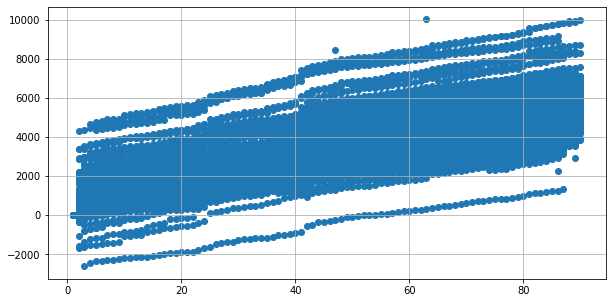

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(df.progrnumber, df.journeytime)
plt.grid()

Journey times are sometimes negative. Removing any stop from a journey that had a negative journey time anywhere as the whole trip could be offset

In [9]:
dftmp = df[(df.journeytime <= 0) & (df.progrnumber > 1)]
df = df[~df['date'].isin(dftmp['date']) | ~df['tripid'].isin(dftmp['tripid'])]
print(len(df),  "rows")

363904 rows


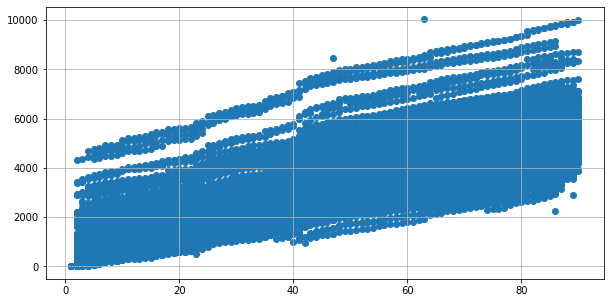

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(df.progrnumber, df.journeytime)
plt.grid()

## Journey time vs Month

In [11]:
dfTotalJourney = df.groupby(['date','tripid']).max() #get the max journey time for a stop on a trip ,i.e. the last stop
dfTotalJourney

progrnumber  stopActualArr  journeytime  dwelltime  rain  \
date       tripid                                                              
2018-01-01 5955785           86          41351         4768        647   0.0   
           5955787           89          51000         4788        451   0.2   
           5955789           86          60201         4337        194   0.0   
           5955791           86          70188         4768        214   0.0   
           5955793           86          79206         4279        748   0.0   
...                         ...            ...          ...        ...   ...   
2018-10-27 8059369           87          28872         4862       1288   0.0   
           8059371           90          43511         4996        442   0.0   
           8059373           86          56025         5660        170   0.0   
           8059375           87          68567         5332        469   0.0   
           8059377           87          80754         5136       1193   0.0   

                    temp  humidity  pressure  weekday  month  hour  
date       tripid                                                   
2018-01-01 5955785   6.7        79     994.1        0      1    11  
           5955787   7.5        81     998.3        0      1    14  
           5955789   7.3        75    1001.9        0      1    16  
           5955791   5.7        81    1006.2        0      1    19  
           5955793   5.0        79    1008.5        0      1    22  
...                  ...       ...       ...      ...    ...   ...  
2018-10-27 8059369   2.8        80    1022.5        5     10     8  
           8059371   7.2        64    1023.0        5     10    12  
           8059373   6.9        59    1022.7        5     10    15  
           8059375   4.9        68    1025.1        5     10    19  
           8059377   1.9        74    1026.3        5     10    22  

[4318 rows x 11 columns]

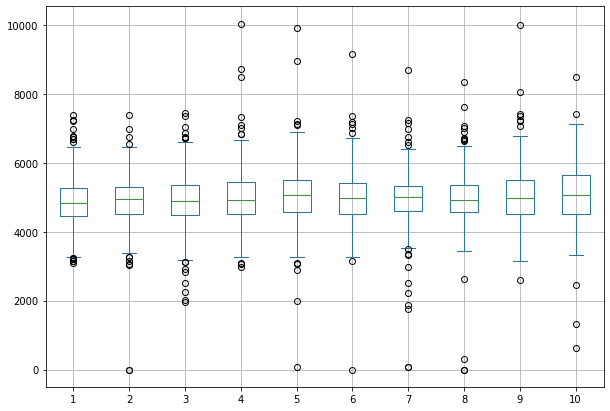

In [12]:
plt.rcParams["figure.figsize"] = (10, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('month').cumcount()).pivot('index','month','journeytime').plot(kind='box')
plt.grid()

some small variation in the boxplots. Doesn't look very promising but not reason enough to exclude yet

## Journey time vs Weekday

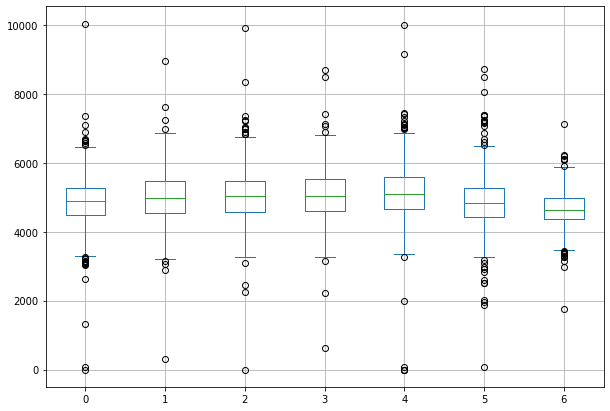

In [13]:
plt.rcParams["figure.figsize"] = (10, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('weekday').cumcount()).pivot('index','weekday','journeytime').plot(kind='box')
plt.grid()

more variation here for weekday, more promising particularly for the weekend

## Journey time vs Hour

In [14]:
dfTotalJourney.hour %= 24

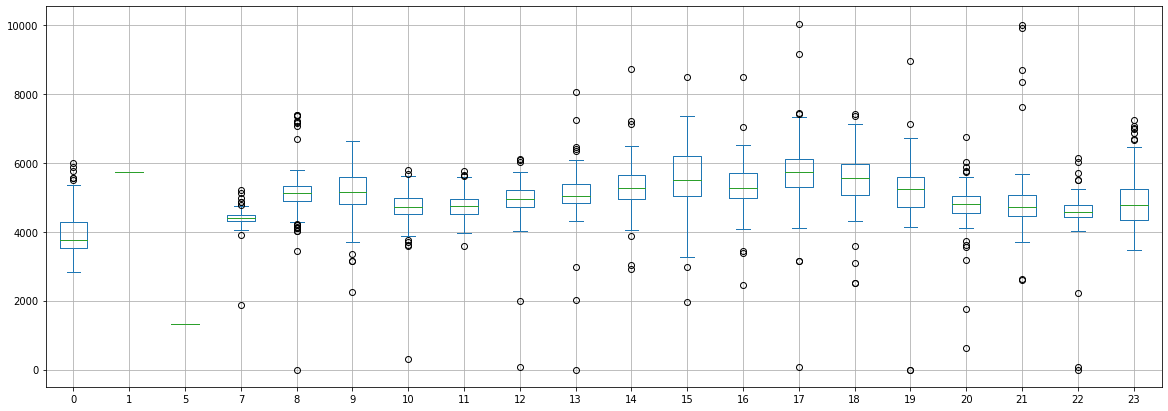

In [15]:
plt.rcParams["figure.figsize"] = (20, 7)
dfTotalJourney.assign(index=dfTotalJourney.groupby('hour').cumcount()).pivot('index','hour','journeytime').plot(kind='box')
plt.grid()

some variation in the hour of the day the route finishes. appears to be cyclical, with 2 peaks and troughs. Maybe ausing some sort of trigonometric function or polynomial to model as well as having separate factors for each month.

## Journey time vs Rain

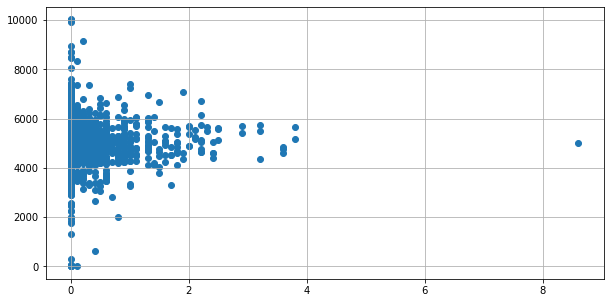

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.rain, dfTotalJourney.journeytime)
plt.grid()

looks like a normal distribution of journey times. The heavier rain is just clumped around the mean. This doesn't appear to have much predictive power.

## Journey time vs Temperature

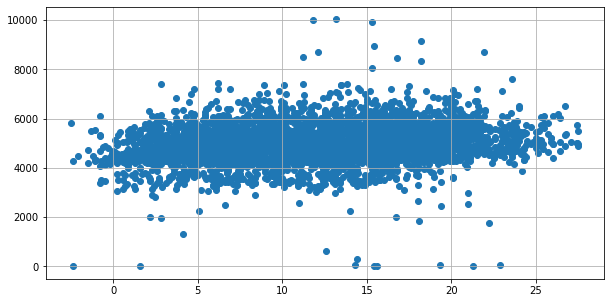

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.temp, dfTotalJourney.journeytime)
plt.grid()

looks like temperature doesn't have a correlation with the total journey time either, just clumped around the middle with no apparent relationship

## Journey time vs Humidity & Journey time vs Pressure

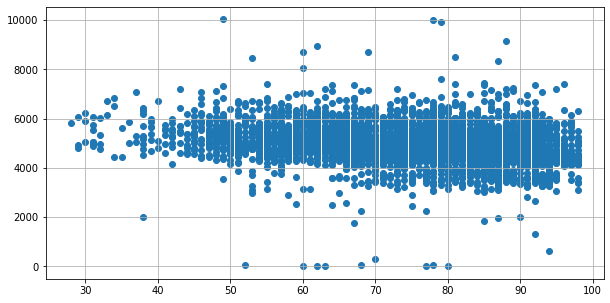

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.humidity, dfTotalJourney.journeytime)
plt.grid()

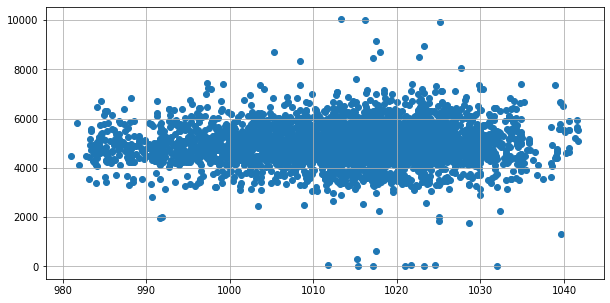

In [19]:
plt.figure(figsize=(10,5))
plt.scatter(dfTotalJourney.pressure, dfTotalJourney.journeytime)
plt.grid()

First plot is humidity and appears to have a slight negative relationship with journey time so will look to see if it's useful.

Second plot is pressure and doesn't appear to have any meaningful relationship to journey time. It's clumped aroun=d the centre like temperature

# Linear regression model for total trip time

In [20]:
dfTotalJourney.head(3)

progrnumber  stopActualArr  journeytime  dwelltime  rain  \
date       tripid                                                              
2018-01-01 5955785           86          41351         4768        647   0.0   
           5955787           89          51000         4788        451   0.2   
           5955789           86          60201         4337        194   0.0   

                    temp  humidity  pressure  weekday  month  hour  
date       tripid                                                   
2018-01-01 5955785   6.7        79     994.1        0      1    11  
           5955787   7.5        81     998.3        0      1    14  
           5955789   7.3        75    1001.9        0      1    16

In [21]:
#removing rain, temp, pressure as no correlation is apparent
#removing stopActualArr as journeytime is calculated from it
#removing journeytime as I am modelling the total journey
#dwelltime also removed as it is part of the journeytime and so can't be used to predict ahead of time
#keeping date and tripid for ID purposes
dfLinear = dfTotalJourney.drop(columns = ['stopActualArr','rain','temp','pressure','progrnumber','dwelltime'])

In [22]:
dfLinear.head(3)

journeytime  humidity  weekday  month  hour
date       tripid                                              
2018-01-01 5955785         4768        79        0      1    11
           5955787         4788        81        0      1    14
           5955789         4337        75        0      1    16

In [23]:
dfLinear.month = dfLinear.month.astype('category')
dfLinear.hour = dfLinear.hour.astype('category')
dfLinear.weekday = dfLinear.weekday.astype('category')

In [24]:
monthlyDummies = pd.get_dummies(dfLinear.month, prefix='m', drop_first=True)
hourlyDummies = pd.get_dummies(dfLinear.hour,prefix='h', drop_first=True)
dailyDummies = pd.get_dummies(dfLinear.weekday, prefix='d', drop_first=True)

In [25]:
dfLinear = pd.concat([dfLinear,monthlyDummies,hourlyDummies,dailyDummies], axis = 1)

In [26]:
dfLinear.drop(columns=['month','hour','weekday'], inplace=True)

In [27]:
dfLinear.head(3)

journeytime  humidity  m_2  m_3  m_4  m_5  m_6  m_7  m_8  \
date       tripid                                                              
2018-01-01 5955785         4768        79    0    0    0    0    0    0    0   
           5955787         4788        81    0    0    0    0    0    0    0   
           5955789         4337        75    0    0    0    0    0    0    0   

                    m_9  ...  h_20  h_21  h_22  h_23  d_1  d_2  d_3  d_4  d_5  \
date       tripid        ...                                                    
2018-01-01 5955785    0  ...     0     0     0     0    0    0    0    0    0   
           5955787    0  ...     0     0     0     0    0    0    0    0    0   
           5955789    0  ...     0     0     0     0    0    0    0    0    0   

                    d_6  
date       tripid        
2018-01-01 5955785    0  
           5955787    0  
           5955789    0  

[3 rows x 36 columns]

In [28]:
for i in dfLinear:
    dfLinear[i] = dfLinear[i].astype('int')

In [29]:
Xfeatures = dfLinear.columns[dfLinear.columns != 'journeytime']
Xfeatures = Xfeatures.drop(['humidity'])
X = dfLinear[Xfeatures] #separate target feature from predicitve features for train test split
y = dfLinear.journeytime

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

In [30]:
lmodel = LinearRegression().fit(Xtrain, ytrain)
rfc = RandomForestRegressor(oob_score=True, random_state=1)
rfc.fit(Xtrain, ytrain)

RandomForestRegressor(oob_score=True, random_state=1)

In [31]:
featureImportance = pd.DataFrame({'feature': Xfeatures, 'importance':lmodel.coef_})
featureImportance.sort_values('importance', ascending=False)

,feature,importance
9,h_1,1909.731864
21,h_17,1817.297486
19,h_15,1681.827156
22,h_18,1597.034315
18,h_14,1426.463761
20,h_16,1387.382560
23,h_19,1288.736682
13,h_9,1203.873616
17,h_13,1171.872617
12,h_8,1159.300783


In [32]:
trainPredictions = lmodel.predict(Xtrain)
rfcPrediction = rfc.predict(Xtrain)

In [33]:
trueVsPredicted = pd.concat([ytrain, pd.DataFrame(trainPredictions, columns=['Linear'], index=Xtrain.index)], axis=1)
trueVsPredicted.head(5)

,,journeytime,Linear
date,tripid,,
2018-07-01,7142159,4702,4267.978524
2018-07-12,7162050,5187,5301.583373
2018-05-14,6763794,4474,4403.200648
2018-03-26,6420221,4905,4947.558497
2018-04-05,6597242,4873,5214.451093


In [34]:
print('Linear Regression:')
printMetrics(ytrain, trainPredictions)
print('\nRandom Forest:')
printMetrics(ytrain, rfcPrediction)

Linear Regression:
MAE:  408.5545679601503
RMSE:  612.1275710763096
R2:  0.4018232772063399

Random Forest:
MAE:  321.306675995821
RMSE:  483.368672568316
R2:  0.6270053291406257


# Models for time taken to reach each stop

In [35]:
dfAllStops = df.drop(columns = ['stopActualArr','rain','temp','pressure','dwelltime'])

In [36]:
dfAllStops.hour %= 24
dfAllStops.head(3)

,date,tripid,progrnumber,journeytime,humidity,weekday,month,hour
0,2018-01-01,5955785,1,0,79,0,1,10
1,2018-01-01,5955785,2,34,79,0,1,10
2,2018-01-01,5955785,3,138,79,0,1,10


In [37]:
dfAllStops.month = dfAllStops.month.astype('category')
dfAllStops.hour = dfAllStops.hour.astype('category')
dfAllStops.weekday = dfAllStops.weekday.astype('category')

In [38]:
monthDummies = pd.get_dummies(dfAllStops.month, prefix='m', drop_first=True)
hourDummies = pd.get_dummies(dfAllStops.hour,prefix='h', drop_first=True)
dayDummies = pd.get_dummies(dfAllStops.weekday, prefix='d', drop_first=True)

In [39]:
dfAllStops = pd.concat([dfAllStops,monthDummies,hourDummies,dayDummies], axis=1)
dfAllStops.drop(columns=['month','hour','weekday'], inplace=True)
dfAllStops.head(3)

,date,tripid,progrnumber,journeytime,humidity,m_2,m_3,m_4,m_5,m_6,...,h_20,h_21,h_22,h_23,d_1,d_2,d_3,d_4,d_5,d_6
0,2018-01-01,5955785,1,0,79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,5955785,2,34,79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,5955785,3,138,79,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
for i in dfAllStops:
    dfAllStops[i] = dfAllStops[i].astype('int')

In [41]:
Xfeatures = dfAllStops.columns[dfAllStops.columns != 'journeytime']
Xfeatures = Xfeatures.drop(['date','tripid','humidity']) #removed humidity due to low effect
X = dfAllStops[Xfeatures] #separate target feature from predicitve features for train test split
y = dfAllStops.journeytime

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.7, random_state=1)

In [42]:
l2model = LinearRegression().fit(Xtrain, ytrain)
rfc = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=1)

In [43]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor(oob_score=True, random_state=1)

In [44]:
trainPredictions = l2model.predict(Xtrain)
rfcPrediction = rfc.predict(Xtrain)

In [45]:
featureImportance = pd.DataFrame({'feature': Xfeatures, 'importance':l2model.coef_})
featureImportance.sort_values('importance', ascending=False)

,feature,importance
10,h_1,1.574360e+03
24,h_17,1.413980e+03
25,h_18,1.335890e+03
23,h_16,1.303554e+03
22,h_15,1.279443e+03
29,h_22,1.195708e+03
21,h_14,1.193700e+03
15,h_8,1.123987e+03
20,h_13,1.103198e+03
26,h_19,9.973171e+02


In [46]:
trueVsPredicted = pd.concat([ytrain, pd.DataFrame(trainPredictions, columns=['Predicted'], index=Xtrain.index)], axis=1)
trueVsPredicted.head(5)

,journeytime,Predicted
215182,995,1223.436647
213460,4093,3962.687016
78033,895,1047.081507
298500,1951,2328.264980
110009,3622,3409.779215


In [47]:
print('Linear Regression:')
printMetrics(ytrain, trainPredictions)
print('\nRandom Forest:')
printMetrics(ytrain, rfcPrediction)

Linear Regression:
MAE:  316.1153517048372
RMSE:  453.76897554434504
R2:  0.9180115452476223

Random Forest:
MAE:  143.50541101721018
RMSE:  239.39607443433377
R2:  0.9771799205865639
